In [1]:
pip install numpy torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np

class ZooEnvironment:
    def __init__(self):
        self.grid_size = 6
        self.state = (1, 0)  # Initial state
        self.exit = (5, 5)  # Exit position
        self.action_space = 4  # Number of actions: up, down, left, right
        self.state_space = 2  # State space size (x, y coordinates)
        self.animals = {(0, 2), (1, 5), (4, 2)}
        self.tunnels = {(3, 5): (0, 5), (1, 1): (4, 5)}
        self.cleaning = {(2, 5)}

    def reset(self):
        self.state = (1, 0)
        return np.array(self.state)

    def step(self, action):
        x, y = self.state
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        self.state = (x, y)
        reward = -1  # Default penalty for each move
        done = self.state == self.exit

        if self.state in self.animals:
            reward += 10  # Reward for visiting animals
        if self.state in self.cleaning:
            reward -= 5  # Penalty for entering cleaning area
        if done:
            reward += 25  # Bonus for reaching the exit

        return np.array(self.state), reward, done

    def is_terminal_state(self):
        return self.state == self.exit


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DuelingDQN(state_size, action_size)
        self.target_model = DuelingDQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(state)
        return act_values.max(1)[1].item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())


In [10]:
import numpy as np

env = ZooEnvironment()
agent = DQNAgent(env.state_space, env.action_space)
episodes = 1000

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay(32)
    agent.update_target_model()
    print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")

    if e % 10 == 0:
        print


/var/folders/j4/8t1hkd6s73b83jybzsvpw5dc0000gn/T/ipykernel_5318/1819164905.py:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:277.)
  states = torch.FloatTensor(states)


Episode: 1/1000, Score: -49, Epsilon: 0.99
Episode: 2/1000, Score: 26, Epsilon: 0.99
Episode: 3/1000, Score: 46, Epsilon: 0.99
Episode: 4/1000, Score: -98, Epsilon: 0.98
Episode: 5/1000, Score: -45, Epsilon: 0.98
Episode: 6/1000, Score: -18, Epsilon: 0.97
Episode: 7/1000, Score: -41, Epsilon: 0.97
Episode: 8/1000, Score: -3, Epsilon: 0.96
Episode: 9/1000, Score: 20, Epsilon: 0.96
Episode: 10/1000, Score: 50, Epsilon: 0.95
Episode: 11/1000, Score: 33, Epsilon: 0.95
Episode: 12/1000, Score: 46, Epsilon: 0.94
Episode: 13/1000, Score: -17, Epsilon: 0.94
Episode: 14/1000, Score: 101, Epsilon: 0.93
Episode: 15/1000, Score: -67, Epsilon: 0.93
Episode: 16/1000, Score: -157, Epsilon: 0.92
Episode: 17/1000, Score: 42, Epsilon: 0.92
Episode: 18/1000, Score: 22, Epsilon: 0.91
Episode: 19/1000, Score: -59, Epsilon: 0.91
Episode: 20/1000, Score: 71, Epsilon: 0.90
Episode: 21/1000, Score: 74, Epsilon: 0.90
Episode: 22/1000, Score: 10, Epsilon: 0.90
Episode: 23/1000, Score: 159, Epsilon: 0.89
Episode:

In [11]:
import matplotlib.pyplot as plt

# Initialize metrics storage
all_rewards = []
epsilon_values = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay(32)
    agent.update_target_model()
    
    # Store metrics
    all_rewards.append(total_reward)
    epsilon_values.append(agent.epsilon)
    
    print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")


Episode: 1/1000, Score: 910, Epsilon: 0.01
Episode: 2/1000, Score: 4460, Epsilon: 0.01
Episode: 3/1000, Score: 3990, Epsilon: 0.01
Episode: 4/1000, Score: 3855, Epsilon: 0.01
Episode: 5/1000, Score: 4430, Epsilon: 0.01
Episode: 6/1000, Score: 4430, Epsilon: 0.01
Episode: 7/1000, Score: 1360, Epsilon: 0.01
Episode: 8/1000, Score: -420, Epsilon: 0.01
Episode: 9/1000, Score: 1150, Epsilon: 0.01
Episode: 10/1000, Score: -350, Epsilon: 0.01
Episode: 11/1000, Score: 3970, Epsilon: 0.01
Episode: 12/1000, Score: -200, Epsilon: 0.01
Episode: 13/1000, Score: 4440, Epsilon: 0.01
Episode: 14/1000, Score: 1090, Epsilon: 0.01
Episode: 15/1000, Score: 4450, Epsilon: 0.01
Episode: 16/1000, Score: 5, Epsilon: 0.01
Episode: 17/1000, Score: 3350, Epsilon: 0.01
Episode: 18/1000, Score: 3250, Epsilon: 0.01
Episode: 19/1000, Score: 2870, Epsilon: 0.01
Episode: 20/1000, Score: 4430, Epsilon: 0.01
Episode: 21/1000, Score: 3860, Epsilon: 0.01
Episode: 22/1000, Score: 2930, Epsilon: 0.01
Episode: 23/1000, Score

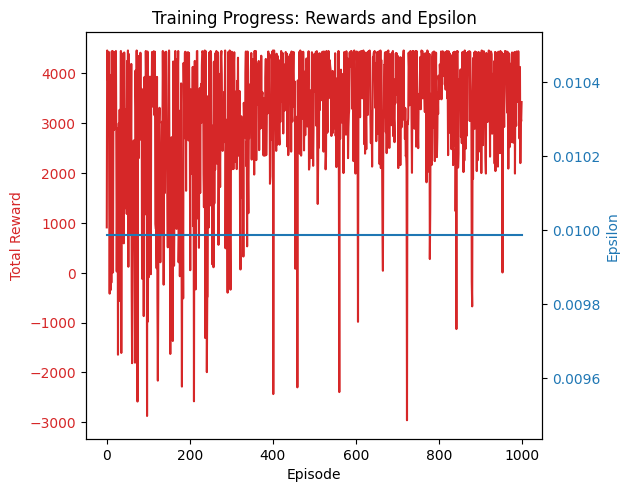

In [12]:
def plot_metrics(rewards, epsilons):
    fig, ax1 = plt.subplots()

    # Plotting total rewards
    color = 'tab:red'
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Total Reward', color=color)
    ax1.plot(rewards, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Plotting epsilon values
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('Epsilon', color=color)
    ax2.plot(epsilons, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title('Training Progress: Rewards and Epsilon')
    plt.show()

plot_metrics(all_rewards, epsilon_values)


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque

class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.value_stream = nn.Linear(128, 1)
        self.advantage_stream = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        value = self.value_stream(x)
        advantages = self.advantage_stream(x)
        q_values = value + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class PrioritizedReplayBuffer:
    def __init__(self, capacity=10000, alpha=0.6):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha

    def add(self, error, experience):
        priority = (abs(error) + 1e-5) ** self.alpha
        self.buffer.append(experience)
        self.priorities.append(priority)

    def sample(self, batch_size):
        scaled_priorities = np.array(self.priorities) / sum(self.priorities)
        sampled_indices = np.random.choice(len(self.buffer), batch_size, p=scaled_priorities)
        sampled_experiences = [self.buffer[idx] for idx in sampled_indices]
        return sampled_experiences

    def update_priorities(self, indices, errors):
        for idx, error in zip(indices, errors):
            priority = (abs(error) + 1e-5) ** self.alpha
            self.priorities[idx] = priority

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = PrioritizedReplayBuffer()
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DuelingDQN(state_size, action_size)
        self.target_model = DuelingDQN(state_size, action_size)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def remember(self, state, action, reward, next_state, done):
        self.memory.add(0, (state, action, reward, next_state, done))  # Initial error is 0

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model(state)
        return act_values.max(1)[1].item()

    def replay(self, batch_size):
        minibatch = self.memory.sample(batch_size)
        if not minibatch:
            return
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.BoolTensor(dones)

        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (~dones)

        errors = torch.abs(current_q_values - expected_q_values).data.numpy()
        self.memory.update_priorities(range(len(minibatch)), errors)

        loss = nn.MSELoss()(current_q_values, expected_q_values.detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

class ZooEnvironment:
    def __init__(self):
        self.grid_size = 6
        self.state = (1, 0)  # Initial state
        self.exit = (5, 5)  # Exit position
        self.action_space = 4  # Number of actions: up, down, left, right
        self.state_space = 2  # State space size (x, y coordinates)
        self.animals = {(0, 2), (1, 5), (4, 2)}
        self.tunnels = {(3, 5): (0, 5), (1, 1): (4, 5)}
        self.cleaning = {(2, 5)}
        self.visited_animals = set()  # Initialize the set of visited animals

    def reset(self):
        self.state = (1, 0)
        self.visited_animals = set()  # Reset visited animals on each new episode
        return np.array(self.state)

    def step(self, action):
        x, y = self.state
        if action == 0:  # Up
            x = max(0, x - 1)
        elif action == 1:  # Down
            x = min(self.grid_size - 1, x + 1)
        elif action == 2:  # Left
            y = max(0, y - 1)
        elif action == 3:  # Right
            y = min(self.grid_size - 1, y + 1)

        self.state = (x, y)
        reward = -1  # Default penalty for each step

        if self.state in self.animals:
            if self.state not in self.visited_animals:
                self.visited_animals.add(self.state)
                reward += 5  # Reward for visiting a new animal

        if self.state in self.cleaning:
            reward -= 3  # Penalty for moving into a cleaning area

        done = self.state == self.exit
        if done:
            if len(self.visited_animals) >= 3:
                reward += 20  # Reward for exiting after visiting at least 3 animals
            else:
                reward -= 7  # Penalty for exiting without visiting all required animals

        return np.array(self.state), reward, done

env = ZooEnvironment()
agent = DQNAgent(env.state_space, env.action_space)
episodes = 1000

for e in range(episodes):
    state = env.reset()
    total_reward = 0
    for time in range(500):
        action = agent.act(state)
        next_state, reward, done = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    agent.replay(32)
    agent.update_target_model()
    print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")


Episode: 1/1000, Score: -64, Epsilon: 0.99
Episode: 2/1000, Score: -191, Epsilon: 0.99
Episode: 3/1000, Score: -258, Epsilon: 0.99
Episode: 4/1000, Score: -104, Epsilon: 0.98
Episode: 5/1000, Score: -71, Epsilon: 0.98
Episode: 6/1000, Score: -181, Epsilon: 0.97
Episode: 7/1000, Score: -119, Epsilon: 0.97
Episode: 8/1000, Score: -515, Epsilon: 0.96
Episode: 9/1000, Score: -229, Epsilon: 0.96
Episode: 10/1000, Score: -77, Epsilon: 0.95
Episode: 11/1000, Score: -262, Epsilon: 0.95
Episode: 12/1000, Score: -419, Epsilon: 0.94
Episode: 13/1000, Score: -261, Epsilon: 0.94
Episode: 14/1000, Score: -136, Epsilon: 0.93
Episode: 15/1000, Score: -423, Epsilon: 0.93
Episode: 16/1000, Score: -149, Epsilon: 0.92
Episode: 17/1000, Score: -109, Epsilon: 0.92
Episode: 18/1000, Score: -104, Epsilon: 0.91
Episode: 19/1000, Score: -407, Epsilon: 0.91
Episode: 20/1000, Score: -181, Epsilon: 0.90
Episode: 21/1000, Score: -74, Epsilon: 0.90
Episode: 22/1000, Score: -180, Epsilon: 0.90
Episode: 23/1000, Score

Episode: 1/1000, Score: -88, Epsilon: 0.99
Episode: 2/1000, Score: -40, Epsilon: 0.99
Episode: 3/1000, Score: -48, Epsilon: 0.99
Episode: 4/1000, Score: -114, Epsilon: 0.98
Episode: 5/1000, Score: -277, Epsilon: 0.98
Episode: 6/1000, Score: -97, Epsilon: 0.97
Episode: 7/1000, Score: -498, Epsilon: 0.97
Episode: 8/1000, Score: -23, Epsilon: 0.96
Episode: 9/1000, Score: -63, Epsilon: 0.96
Episode: 10/1000, Score: -146, Epsilon: 0.95
Episode: 11/1000, Score: -106, Epsilon: 0.95
Episode: 12/1000, Score: -28, Epsilon: 0.94
Episode: 13/1000, Score: -319, Epsilon: 0.94
Episode: 14/1000, Score: -554, Epsilon: 0.93
Episode: 15/1000, Score: -66, Epsilon: 0.93
Episode: 16/1000, Score: -71, Epsilon: 0.92
Episode: 17/1000, Score: -169, Epsilon: 0.92
Episode: 18/1000, Score: -156, Epsilon: 0.91
Episode: 19/1000, Score: -21, Epsilon: 0.91
Episode: 20/1000, Score: -137, Epsilon: 0.90
Episode: 21/1000, Score: -260, Epsilon: 0.90
Episode: 22/1000, Score: -43, Epsilon: 0.90
Episode: 23/1000, Score: -21, 

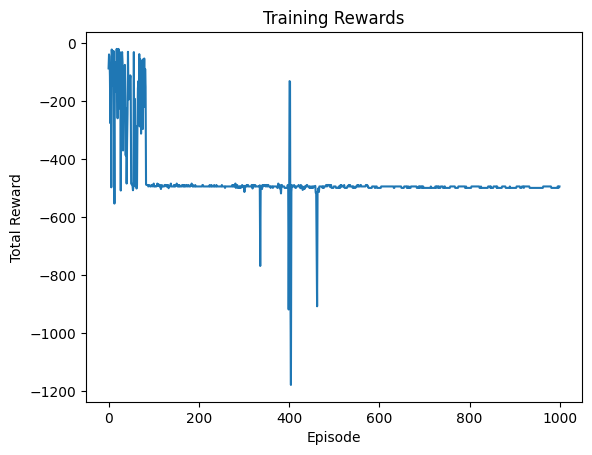

KeyboardInterrupt: 

In [17]:
import matplotlib.pyplot as plt

def plot_rewards(rewards, title="Rewards"):
    plt.plot(rewards)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

# Training
def train_agent(agent, env, episodes=1000):
    total_rewards = []
    for e in range(episodes):
        state = env.reset()
        total_reward = 0
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.replay(32)
        agent.update_target_model()
        total_rewards.append(total_reward)
        print(f"Episode: {e+1}/{episodes}, Score: {total_reward}, Epsilon: {agent.epsilon:.2f}")
    return total_rewards

# Evaluate
def evaluate_agent(agent, env, episodes=100):
    total_rewards = []
    for _ in range(episodes):
        state = env.reset()
        total_reward = 0
        while True:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward
            if done:
                break
        total_rewards.append(total_reward)
    return total_rewards

agent = DQNAgent(env.state_space, env.action_space)
train_rewards = train_agent(agent, env)
plot_rewards(train_rewards, title="Training Rewards")

eval_rewards = evaluate_agent(agent, env)
plot_rewards(eval_rewards, title="Evaluation Rewards")


In [ ]:
def visualize_agent(agent, env, episodes=3):
    for _ in range(episodes):
        state = env.reset()
        print("Initial State:")
        env.render()
        total_reward = 0
        while True:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward
            print(f"Action: {action}, Reward: {reward}")
            env.render()
            if done:
                print(f"Total Reward: {total_reward}")
                break

visualize_agent(agent, env)


In [20]:
pip install 'ray[rllib]'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 19.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 16.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 9.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 31.8 MB/s eta 0:00:00a 0:00

In [3]:
import ray
from ray import tune
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray.rllib.env.atari_wrappers import wrap_deepmind

# Initialize Ray
ray.init()

# Register Atari environment with RLlib
register_env("atari_env", lambda config: wrap_deepmind("PongNoFrameskip-v4", frame_stack=True))

# Configuration for PPO trainer
config = {
    "env": "atari_env",        # Atari environment
    "num_gpus": 0,             # Use CPU for training
    "num_workers": 4,          # Number of workers for parallelism
    "framework": "torch",      # Use PyTorch backend
    "lr": 5e-4,                # Learning rate
    "gamma": 0.99,             # Discount factor
    "train_batch_size": 4000,  # Batch size
    "sgd_minibatch_size": 500, # Mini-batch size for SGD
    "num_sgd_iter": 4,         # Number of SGD iterations
    "entropy_coeff": 0.01,     # Entropy coefficient
    "vf_loss_coeff": 0.5,      # Value function loss coefficient
}

# Train the PPO agent
analysis = tune.run(PPOTrainer, config=config, stop={"episode_reward_mean": 18}, checkpoint_at_end=True)

# Checkpoint and results path
checkpoint_path = analysis.get_best_checkpoint(trial=analysis.get_best_trial(metric="episode_reward_mean"))
results_path = analysis.best_logdir

print("Best checkpoint saved at:", checkpoint_path)
print("Results saved at:", results_path)

# Shutdown Ray
ray.shutdown()


ModuleNotFoundError: No module named 'ray.rllib.agents'

In [1]:
import sys
sys.executable


'/Users/prachib/anaconda3/envs/newenv/bin/python'

In [2]:
import sys
print(sys.path)


['/Users/prachib/Documents/Term 2/DRL', '/Users/prachib/anaconda3/envs/newenv/lib/python38.zip', '/Users/prachib/anaconda3/envs/newenv/lib/python3.8', '/Users/prachib/anaconda3/envs/newenv/lib/python3.8/lib-dynload', '', '/Users/prachib/anaconda3/envs/newenv/lib/python3.8/site-packages']


In [4]:
import sys
!{sys.executable} -m pip install rllib


In [6]:
import sys
sys.path.append('/Users/prachib/anaconda3/lib/python3.11/site-packages')


In [3]:
import ray
import ray.rllib as rllib
from ray import tune
from ray.rllib.agents.a3c import A3CTrainer
from ray.tune.registry import register_env
from ray.rllib.env.atari_wrappers import wrap_deepmind

# Initialize Ray
ray.init()

# Register Atari environment with RLlib
register_env("atari_env", lambda config: wrap_deepmind("PongNoFrameskip-v4", frame_stack=True))

# Configuration for A2C trainer
config = {
    "env": "atari_env",        # Atari environment
    "num_gpus": 0,             # Use CPU for training
    "num_workers": 4,          # Number of workers for parallelism
    "framework": "torch",      # Use PyTorch backend
    "lr": 1e-4,                # Learning rate
    "gamma": 0.99,             # Discount factor
    "entropy_coeff": 0.01,     # Entropy coefficient
    "vf_loss_coeff": 0.5,      # Value function loss coefficient
}

# Train the A2C agent
analysis = tune.run(A3CTrainer, config=config, stop={"episode_reward_mean": 18}, checkpoint_at_end=True)

# Checkpoint and results path
checkpoint_path = analysis.get_best_checkpoint(trial=analysis.get_best_trial(metric="episode_reward_mean"))
results_path = analysis.best_logdir

print("Best checkpoint saved at:", checkpoint_path)
print("Results saved at:", results_path)

# Shutdown Ray
ray.shutdown()


ModuleNotFoundError: No module named 'ray.rllib.agents'